In [64]:
import pandas as pd
import re
def parse_log_line(line):
    # Pattern for full line with LPA range
    pattern_full = r"(\d+),(\d+)\s+(\d+)\s+(\d+)\s+([\d.]+)\s+(\d+)\s+([A-Z])\s+([A-Z]{1,2})\s+(\d+)\s+\+\s+(\d+)\s+\[(.+?)\]"
    match_full = re.match(pattern_full, line)

    if match_full:
        # Skip if 'rw' is N (discarding unwanted trace)
        if match_full.group(8) == 'N':
            return None
        return {
            "device": int(match_full.group(1)),
            "section": int(match_full.group(2)),
            "cpu_id": int(match_full.group(3)),
            "sequence": int(match_full.group(4)),
            "timestamp": float(match_full.group(5)),
            "pid": int(match_full.group(6)),
            "op_type": match_full.group(7),
            "rw": match_full.group(8),
            "lpa_start": int(match_full.group(9)),
            "lpa_len": int(match_full.group(10)),
            "thread": match_full.group(11),
        }

    # Pattern for lines like: U   N [java] 1
    pattern_short = r"(\d+),(\d+)\s+(\d+)\s+(\d+)\s+([\d.]+)\s+(\d+)\s+([A-Z])\s+([A-Z]{1,2})\s+\[(.+?)\]\s*(\d+)?"
    match_short = re.match(pattern_short, line)

    if match_short:
        if match_short.group(8) == 'N':
            return None  # Discard
        return {
            "device": int(match_short.group(1)),
            "section": int(match_short.group(2)),
            "cpu_id": int(match_short.group(3)),
            "sequence": int(match_short.group(4)),
            "timestamp": float(match_short.group(5)),
            "pid": int(match_short.group(6)),
            "op_type": match_short.group(7),
            "rw": match_short.group(8),
            "lpa_start": None,
            "lpa_len": None,
            "thread": match_short.group(9),
        }

    return None  # Line does not match any format

In [65]:
log_file = "ssdtrace-00"
max_cnt = 50000
total_number_of_bin = 200
parsed_data = []
with open(log_file, "r") as f:
    cnt = 0
    for line in f:
        result = parse_log_line(line.strip())
        if cnt==max_cnt:
            break
        if result: 
            parsed_data.append(result)
        cnt += 1
df = pd.DataFrame(parsed_data)
df.head()
# get the max lpa_len
max_lpa_len = df['lpa_len'].max() if 'lpa_len' in df else None
if max_lpa_len is not None:
    print(f"Max LPA Length: {max_lpa_len}")

Max LPA Length: 2048


In [66]:
# only lpa_start, lpa_len remains
df = df.drop(columns=["device", "section", "cpu_id", "sequence", "timestamp", "pid", "thread"])
df.head()

,op_type,rw,lpa_start,lpa_len
0,Q,R,282624,8
1,G,R,282624,8
2,I,RS,282624,8
3,D,RS,282624,8
4,C,RS,282624,8


In [67]:
write_count = df[df['rw'] == 'W'].shape[0]
print(f"Number of W Operations: {write_count}")
write_count = df[df['rw'] == 'I'].shape[0]
print(f"Number of I Operations: {write_count}")
write_count = df[df['rw'] == 'WS'].shape[0]
print(f"Number of WS Operations: {write_count}")
write_count = df[df['rw'] == 'PUT'].shape[0]
print(f"Number of PUT Operations: {write_count}")

Number of W Operations: 0
Number of I Operations: 0
Number of WS Operations: 5850
Number of PUT Operations: 0


In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# create folder for filtered data if it doesn't exist
output_dir = "filtered_data"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

write_operations = df[df['rw'].isin(['W', 'I', 'WS', 'PUT'])][['lpa_start', 'lpa_len']]

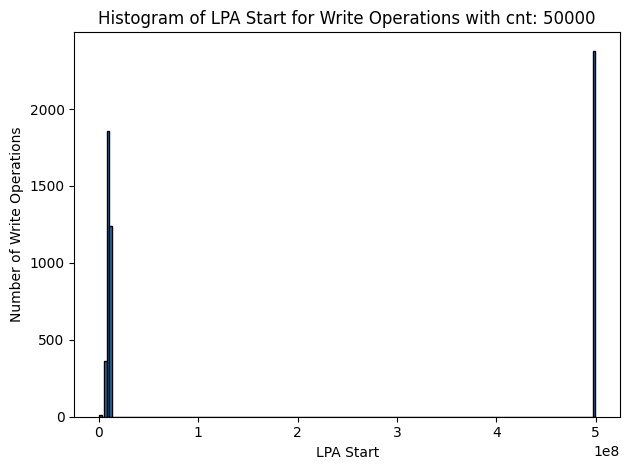

In [69]:
# 畫 histogram 並取得詳細資料
counts, bin_edges, patches = plt.hist(write_operations['lpa_start'], bins=total_number_of_bin, edgecolor='black')

plt.xlabel('LPA Start')
plt.ylabel('Number of Write Operations')
plt.title('Histogram of LPA Start for Write Operations with cnt: {}'.format(max_cnt))

# 在每個 bar 上加上標籤（顯示 bin 範圍和數量）
for i in range(len(counts)):
    bin_start = int(bin_edges[i])
    bin_end = int(bin_edges[i+1]) - 1
    count = int(counts[i])
    bin_label = f"{bin_start}~{bin_end}\n({count})"

plt.tight_layout()
plt.show()

In [70]:
# remove range.txt when it exists
if os.path.exists("range.txt"):
    os.remove("range.txt")
with open("range.txt", "a") as f:
    f.write(f"{len(counts)}\n")
for bin_id in range(len(counts)):
    # filter out the dataframe with the first bin's start and end
    bin_start = int(bin_edges[bin_id])
    bin_end = int(bin_edges[bin_id+1]) - 1
    filtered_df = df[(df['lpa_start'] >= bin_start) & (df['lpa_start'] <= bin_end)]
    # show filtered_df's size
    print(f"Filtered DataFrame Size: {filtered_df.shape}")
    # dump filtered dataframe to csv by bin_id
    filtered_df.to_csv(f"filtered_data/bin_{bin_id}.csv", index=False)
    # append the range to range.txt
    with open("range.txt", "a") as f:
        f.write(f"{bin_start} {bin_end}\n")
        print(f"Range {bin_start}~{bin_end} written to range.txt")

Filtered DataFrame Size: (285, 4)
Range 278528~2775197 written to range.txt
Filtered DataFrame Size: (50, 4)
Range 2775198~5271867 written to range.txt
Filtered DataFrame Size: (435, 4)
Range 5271868~7768537 written to range.txt
Filtered DataFrame Size: (1925, 4)
Range 7768538~10265208 written to range.txt
Filtered DataFrame Size: (1300, 4)
Range 10265209~12761878 written to range.txt
Filtered DataFrame Size: (135, 4)
Range 12761879~15258548 written to range.txt
Filtered DataFrame Size: (105, 4)
Range 15258549~17755218 written to range.txt
Filtered DataFrame Size: (115, 4)
Range 17755219~20251889 written to range.txt
Filtered DataFrame Size: (35, 4)
Range 20251890~22748559 written to range.txt
Filtered DataFrame Size: (20, 4)
Range 22748560~25245229 written to range.txt
Filtered DataFrame Size: (75, 4)
Range 25245230~27741900 written to range.txt
Filtered DataFrame Size: (75, 4)
Range 27741901~30238570 written to range.txt
Filtered DataFrame Size: (45, 4)
Range 30238571~32735240 writte